<a href="https://colab.research.google.com/github/KC3P0/NFL-Data/blob/main/Gridiron_Intelligence_2026_NFL_Analytics_with_Draft_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import necessary libraries
!pip install nflreadpy
import pandas as pd
import polars as pl
import re
import nflreadpy as nfl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pbp_data = nfl.load_pbp(seasons=2025)

In [3]:
prospect_data_text = '''
1. Jeremiyah Love – Notre Dame – RB
2. Arvell Reese – Ohio State – LB
3. Peter Woods – Clemson – DT
4. Rueben Bain Jr. – Miami – EDGE
5. Spencer Fano – Utah – OT
6. Caleb Downs – Ohio State – S
7. Ty Simpson – Alabama – QB
8. Keldric Faulk – Auburn – EDGE
9. David Bailey – Texas Tech – EDGE
10. Francis Mauigoa – Miami – OT
11. Dante Moore – Oregon – QB
12. LaNorris Sellers – South Carolina – QB
13. Jordyn Tyson – Arizona State – WR
14. Carnell Tate – Ohio State – WR
15. Caleb Banks – Florida – DT
16. Fernando Mendoza – Indiana – QB
17. Caleb Lomu – Utah – OT
18. Mansoor Delane – LSU – CB
19. Matayo Uiagalelei – Oregon – EDGE
20. Kadyn Proctor – Alabama – OT
21. Germie Bernard – Alabama – WR
22. A'Mauri Washington – Oregon – DT
23. Jermod McCoy – Tennessee – CB
24. Denzel Boston – Washington – WR
25. Kenyon Sadiq – Oregon – TE
26. Colton Hood – Tennessee – CB
27. Chris Bell – Louisville – WR
28. Sonny Styles – Ohio State – LB
29. LT Overton – Alabama – EDGE
30. Olaivavega Ioane – Penn State – OG
31. Zion Young – Missouri – EDGE
32. CJ Allen – Georgia – LB
33. Anthony Hill Jr. – Texas – LB
34. Chris Brazzell II – Tennessee – WR
35. Drew Shelton – Penn State – OT
36. T.J. Parker – Clemson – EDGE
37. Zxavian Harris – Ole Miss – DT
38. Derrick Moore – Michigan – EDGE
39. Avieon Terrell – Clemson – CB
40. Xavier Chaplin – Auburn – OT
41. Damon Wilson II – Missouri – EDGE
42. Justice Haynes – Michigan – RB
43. Makai Lemon – USC – WR
44. R Mason Thomas – Oklahoma – EDGE
45. Bear Alexander – Oregon – DT
46. A.J. Haulcy – LSU – S
47. Max Klare – Ohio State – TE
48. Gabe Jacas – Illinois – EDGE
49. Joe Royer – Cincinnati – TE
50. Zakee Wheatley – Penn State – S
51. Gennings Dunker – Iowa – OT
52. Isaiah World – Oregon – OT
53. Cashius Howell – Texas A&M – EDGE
54. Deontae Lawson – Alabama – LB
55. Malik Muhammad – Texas – CB
56. Tim Keenan III – Alabama – DT
57. Davison Igbinosun – Ohio State – CB
58. Garrett Nussmeier – LSU – QB
59. Jaishawn Barham – Michigan – EDGE
60. Chris Johnson – San Diego State – CB
61. Zachariah Branch – Georgia – WR
62. Dillon Thieneman – Oregon – S
63. Connor Lew – Auburn – C
64. Ja'Kobi Lane – USC – WR
65. Dani Dennis-Sutton – Penn State – EDGE
66. Whit Weeks – LSU – LB
67. Jadarian Price – Notre Dame – RB
68. Carson Beck – Miami – QB
69. Emmanuel Pregnon – Oregon – OG
70. Aamil Wagner – Notre Dame – OT
71. Keon Sabb – Alabama – S
72. DJ McKinney – Colorado – CB
73. Antonio Williams – Clemson – WR
74. Kamari Ramsey – USC – S
75. John Mateer – Oklahoma – QB

Draft Order:
1. Las Vegas Raiders
2. New York Jets
3. Arizona Cardinals
4. Tennessee Titans
5. New York Giants
6. Cleveland Browns
7. Washington Commanders
8. New Orleans Saints
9. Kansas City Chiefs
10. Cincinnati Bengals
11. Miami Dolphins
12. Dallas Cowboys
13. Los Angeles Rams
14. Baltimore Ravens
15. Tampa Bay Buccaneers
16. New York Jets
17. Detroit Lions
18. Minnesota Vikings
19. Carolina Panthers
20. Dallas Cowboys
21. Pittsburgh Steelers
22. Los Angeles Chargers
23. Philadelphia Eagles
24. Cleveland Browns
'''

In [6]:
prospect_pattern = re.compile(r'^(\d+)\.\s*([^,]+?) – ([^–]+?) – (.+)$', re.MULTILINE)
prospect_matches = prospect_pattern.findall(prospect_data_text)
prospects_df = pd.DataFrame([{'Pick Number (Placeholder)': int(m[0]), 'Prospect Name': m[1].strip(), 'College': m[2].strip(), 'Position': m[3].strip()} for m in prospect_matches])

draft_order_pattern = re.compile(r'^(\d+)\.\s*(.+)$', re.MULTILINE)
draft_order_section_start = prospect_data_text.find('Draft Order:')
draft_order_text = prospect_data_text[draft_order_section_start:]
draft_order_matches = draft_order_pattern.findall(draft_order_text)
draft_order_df = pd.DataFrame([{'Pick Number': int(m[0]), 'Team': m[1].strip()} for m in draft_order_matches])

In [7]:
# Calculate EPA Lost per team across various metrics [36-50]
offensive_epa_lost = pbp_data.group_by('posteam').agg(pl.sum('epa').alias('Offensive EPA')).with_columns((pl.col('Offensive EPA') * -1).alias('Offensive EPA Lost')).select('posteam', 'Offensive EPA Lost').rename({'posteam': 'Team'})
defensive_epa_lost = pbp_data.group_by('defteam').agg(pl.sum('epa').alias('Defensive EPA Lost')).rename({'defteam': 'Team'})
opponent_3rd_down_epa_lost = pbp_data.filter((pl.col('down') == 3) & (pl.col('yards_gained') >= pl.col('ydstogo'))).group_by('defteam').agg(pl.sum('epa').alias('Opponent 3rd Down Conversion EPA Lost')).rename({'defteam': 'Team'})
turnover_epa_lost = pbp_data.filter((pl.col('interception') == 1) | (pl.col('fumble_lost') == 1)).group_by('posteam').agg(pl.sum('epa').alias('Turnover EPA Lost')).rename({'posteam': 'Team'})
sack_epa_lost = pbp_data.filter(pl.col('sack') == 1).group_by('posteam').agg(pl.sum('epa').alias('Sack EPA Lost')).rename({'posteam': 'Team'})
penalty_epa_lost = pbp_data.filter(pl.col('penalty_yards') > 0).group_by('posteam').agg(pl.sum('epa').alias('Penalty EPA Lost')).rename({'posteam': 'Team'})

# Merge into comprehensive Game-Losing Factors DataFrame [30, 51, 52]
all_teams_df = pbp_data.select(pl.col('posteam').unique()).rename({'posteam': 'Team'})
game_losing_factors_epa = all_teams_df.join(turnover_epa_lost, on='Team', how='left').join(sack_epa_lost, on='Team', how='left').join(penalty_epa_lost, on='Team', how='left').join(offensive_epa_lost, on='Team', how='left').join(defensive_epa_lost, on='Team', how='left').join(opponent_3rd_down_epa_lost, on='Team', how='left').fill_null(0)

In [8]:
# Refined Factor-to-Position Mapping [53, 55-57, 61]
factor_to_positions = {
    'Turnover EPA Lost': ['QB', 'RB', 'WR', 'TE'],
    'Sack EPA Lost': ['OT', 'OG', 'C', 'QB', 'EDGE', 'DT'], # DT added for balance
    'Penalty EPA Lost': ['DT', 'DB', 'C', 'LB', 'EDGE'], # OT/OG removed for balance
    'Offensive EPA Lost': ['QB', 'WR', 'RB', 'TE', 'OT', 'OG', 'C'],
    'Defensive EPA Lost': ['CB', 'S', 'LB', 'DT', 'EDGE'],
    'Opponent 3rd Down Conversion EPA Lost': ['CB', 'S', 'LB', 'DT', 'EDGE']
}

relevant_positions = list(set([pos for positions in factor_to_positions.values() for pos in positions]))
team_need_scores = game_losing_factors_epa.clone()

for pos in relevant_positions:
    team_need_scores = team_need_scores.with_columns(pl.lit(0.0).alias(f'{pos}_Need_Score'))

for factor, positions in factor_to_positions.items():
    for pos in positions:
        if factor in ['Turnover EPA Lost', 'Sack EPA Lost']:
            team_need_scores = team_need_scores.with_columns((pl.col(f'{pos}_Need_Score') + (pl.col(factor) * -1)).alias(f'{pos}_Need_Score'))
        else:
            team_need_scores = team_need_scores.with_columns((pl.col(f'{pos}_Need_Score') + pl.col(factor).clip(lower_bound=0)).alias(f'{pos}_Need_Score'))


In [9]:
# Final QB Adjustment and Filtering [58, 60, 62]
team_need_scores = team_need_scores.with_columns((pl.col('QB_Need_Score') / 1.5).alias('QB_Need_Score'))
team_need_scores_filtered = team_need_scores.filter(pl.col('Team').is_not_null())

In [11]:
simulated_draft_results = []
available_prospects_df = pl.DataFrame(prospects_df)
team_name_mapping = {'Las Vegas Raiders': 'LV', 'New York Jets': 'NYJ', 'Arizona Cardinals': 'ARI', 'Tennessee Titans': 'TEN', 'New York Giants': 'NYG', 'Cleveland Browns': 'CLE', 'Washington Commanders': 'WAS', 'New Orleans Saints': 'NO', 'Kansas City Chiefs': 'KC', 'Cincinnati Bengals': 'CIN', 'Miami Dolphins': 'MIA', 'Dallas Cowboys': 'DAL', 'Los Angeles Rams': 'LA', 'Baltimore Ravens': 'BAL', 'Tampa Bay Buccaneers': 'TB', 'Detroit Lions': 'DET', 'Minnesota Vikings': 'MIN', 'Carolina Panthers': 'CAR', 'Pittsburgh Steelers': 'PIT', 'Los Angeles Chargers': 'LAC', 'Philadelphia Eagles': 'PHI'}

draft_order_pl = pl.DataFrame(draft_order_df).with_columns(pl.col('Team').replace_strict(team_name_mapping).alias('Abbreviated_Team'))

for pick_num, full_team, abbr_team in draft_order_pl.select(['Pick Number', 'Team', 'Abbreviated_Team']).iter_rows():
    team_row = team_need_scores_filtered.filter(pl.col('Team') == abbr_team)
    if team_row.is_empty(): continue

    # Identify top 5 needs [66-68]
    needs = sorted([(team_row.select(pl.col(f'{p}_Need_Score')).item(), p) for p in relevant_positions], reverse=True)[:5]
    top_5_needs = [n[1] for n in needs]

    # Select Best Player Available matching needs [69-71]
    matches = available_prospects_df.filter(pl.col('Position').is_in(top_5_needs))
    if not matches.is_empty():
        selected = matches.sort('Pick Number (Placeholder)').head(1)
        simulated_draft_results.append({'Pick': pick_num, 'Team': full_team, 'Prospect Name': selected['Prospect Name'].item(), 'Position': selected['Position'].item()})
        available_prospects_df = available_prospects_df.filter(pl.col('Pick Number (Placeholder)') != selected['Pick Number (Placeholder)'].item())

simulated_draft_df = pl.DataFrame(simulated_draft_results)

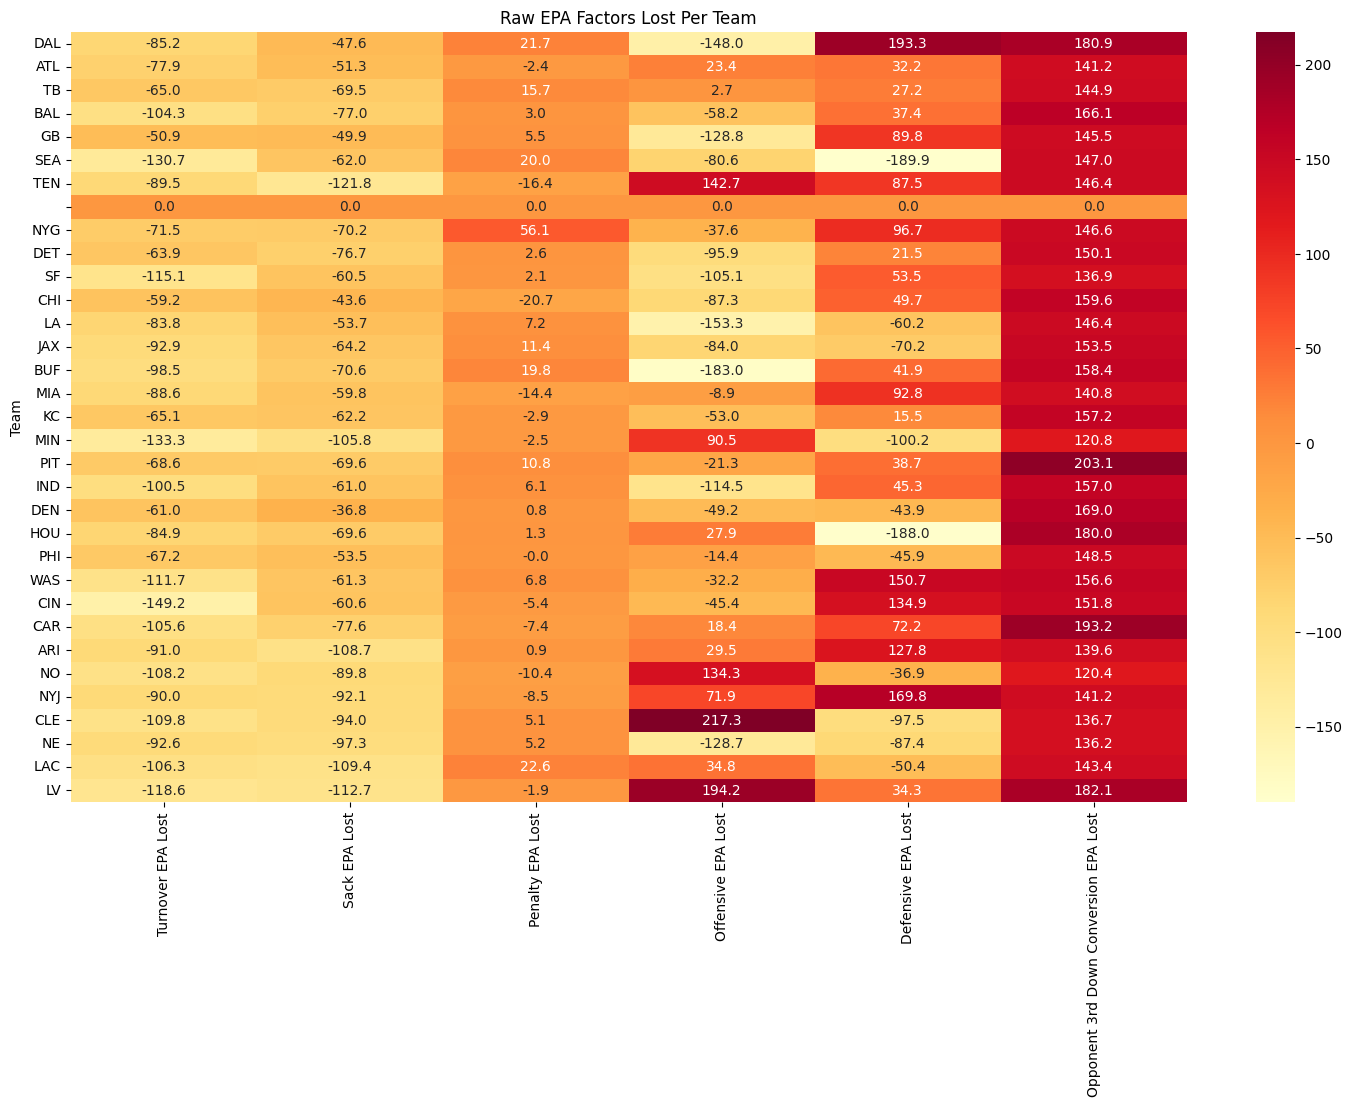

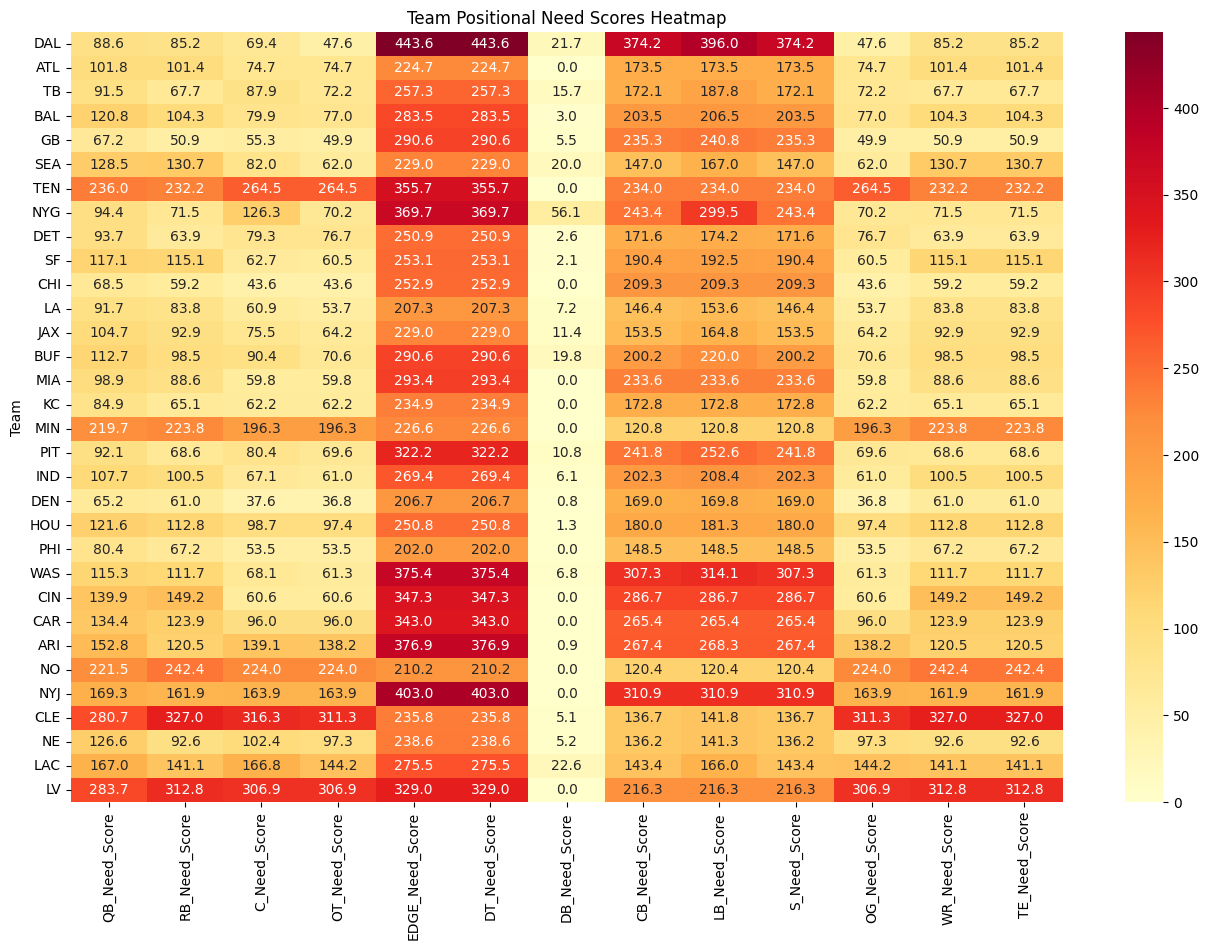

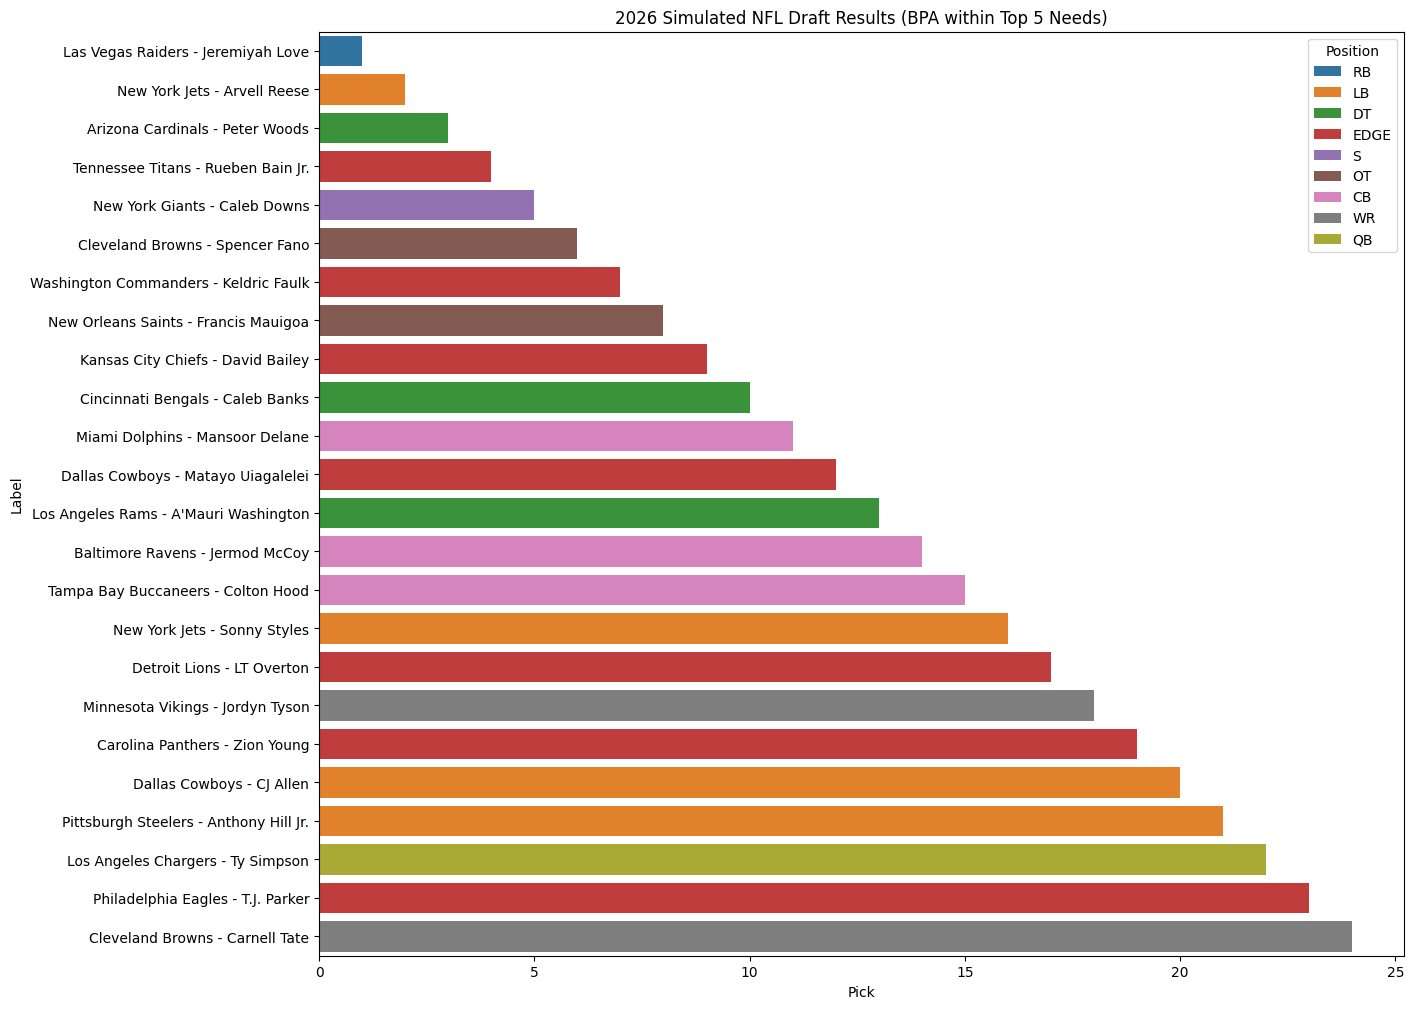

In [12]:
# A. Raw EPA Factors Heatmap: Shows where teams are losing value [72, 77, 78]
epa_factors_pd = game_losing_factors_epa.select(['Team', 'Turnover EPA Lost', 'Sack EPA Lost', 'Penalty EPA Lost', 'Offensive EPA Lost', 'Defensive EPA Lost', 'Opponent 3rd Down Conversion EPA Lost']).to_pandas().set_index('Team')
plt.figure(figsize=(18, 10))
sns.heatmap(epa_factors_pd, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Raw EPA Factors Lost Per Team')
plt.show()

# B. Positional Need Score Heatmap: Highlights league-wide and team-specific weaknesses [56, 74, 79-81]
heatmap_pd = team_need_scores_filtered.to_pandas().set_index('Team')[[f'{p}_Need_Score' for p in relevant_positions]]
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_pd, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Team Positional Need Scores Heatmap')
plt.show()

# C. Draft Results Summary: Displays how teams addressed their deficiencies [82-84]
sim_pd = simulated_draft_df.to_pandas()
sim_pd['Label'] = sim_pd['Team'] + ' - ' + sim_pd['Prospect Name']
plt.figure(figsize=(14, 12))
sns.barplot(x='Pick', y='Label', hue='Position', data=sim_pd, dodge=False)
plt.title('2026 Simulated NFL Draft Results (BPA within Top 5 Needs)')
plt.show()